# **JanataHack: Machine Learning for Banking**

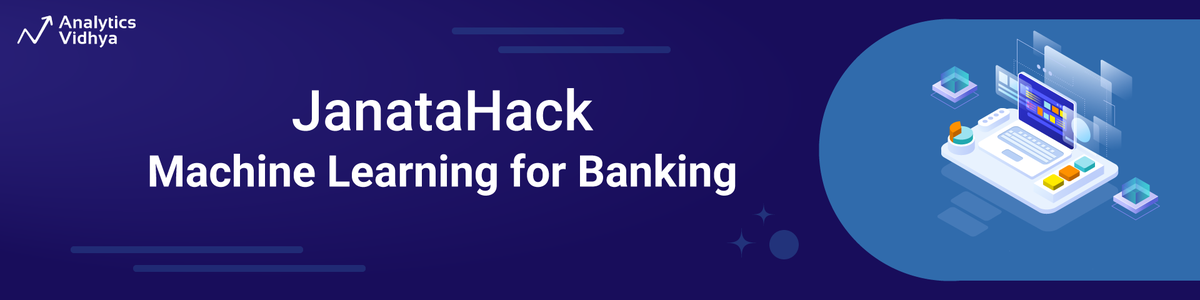

# **Background**

Have you ever wondered how lenders use various factors such as credit score, annual income, the loan amount approved, tenure, debt-to-income ratio etc. and select your interest rates? 

The process, defined as ‘risk-based pricing’, uses a sophisticated algorithm that leverages different determining factors of a loan applicant. Selection of significant factors will help develop a prediction algorithm which can estimate loan interest rates based on clients’ information. On one hand, knowing the factors will help consumers and borrowers to increase their credit worthiness and place themselves in a better position to negotiate for getting a lower interest rate. On the other hand, this will help lending companies to get an immediate fixed interest rate estimation based on clients information.

**Here, your goal is to use a training dataset to predict the loan rate category (1 / 2 / 3) that will be assigned to each loan in our test set.**

You can use any combination of the features in the dataset to make your loan rate category predictions. ***Some features will be easier to use than others.***

# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

# **Starter Code**

Feature information on the data as a .xlsx file for easy lookup  throughout the notebook.

**Data Overview**

Given below is the description of each variable.

In [2]:
variable_definition = pd.read_excel('variable_definition.xlsx',index_col="Variable")
pd.set_option("display.max_colwidth",None)
variable_definition

,Definition
Variable,
Loan_ID,A unique id for the loan.
Loan_Amount_Requested,The listed amount of the loan applied for by the borrower.
Length_Employed,Employment length in years
Home_Owner,"The home ownership status provided by the borrower during registration. Values are: Rent, Own, Mortgage, Other."
Annual_Income,The annual income provided by the borrower during registration.
Income_Verified,"Indicates if income was verified, not verified, or if the income source was verified"
Purpose_Of_Loan,A category provided by the borrower for the loan request.
Debt_To_Income,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested loan, divided by the borrower’s self-reported monthly income."
Inquiries_Last_6Mo,The number of inquiries by creditors during the past 6 months.


In [3]:
print(variable_definition.loc['Home_Owner']['Definition'])

The home ownership status provided by the borrower during registration. Values are: Rent, Own, Mortgage, Other.


In [4]:
def feat_info(col_name):
  print(variable_definition.loc[col_name]['Definition'])

In [5]:
feat_info('Debt_To_Income')

A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested loan, divided by the borrower’s self-reported monthly income.


# **Get the Data**

In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

Check the head of the data.

In [7]:
train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


Checking the shape of the dataframe.

In [8]:
train.shape, test.shape

((164309, 14), (109541, 13))

Get the info of the dataframe.

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_ID                  164309 non-null  int64  
 1   Loan_Amount_Requested    164309 non-null  object 
 2   Length_Employed          156938 non-null  object 
 3   Home_Owner               138960 non-null  object 
 4   Annual_Income            139207 non-null  float64
 5   Income_Verified          164309 non-null  object 
 6   Purpose_Of_Loan          164309 non-null  object 
 7   Debt_To_Income           164309 non-null  float64
 8   Inquiries_Last_6Mo       164309 non-null  int64  
 9   Months_Since_Deliquency  75930 non-null   float64
 10  Number_Open_Accounts     164309 non-null  int64  
 11  Total_Accounts           164309 non-null  int64  
 12  Gender                   164309 non-null  object 
 13  Interest_Rate            164309 non-null  int64  
dtypes: f

Summary statistics of the data.

In [10]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Loan_ID,164309.0,1.008216e+07,47432.067027,10000001.0,10041078.00,10082155.00,10123232.00,10164309.00
Annual_Income,139207.0,7.333116e+04,60377.498294,4000.0,45000.00,63000.00,88697.50,7500000.00
Debt_To_Income,164309.0,1.720719e+01,7.845083,0.0,11.37,16.84,22.78,39.99
Inquiries_Last_6Mo,164309.0,7.816979e-01,1.034747,0.0,0.00,0.00,1.00,8.00
Months_Since_Deliquency,75930.0,3.422936e+01,21.761180,0.0,16.00,31.00,50.00,180.00
Number_Open_Accounts,164309.0,1.119382e+01,4.991813,0.0,8.00,10.00,14.00,76.00
Total_Accounts,164309.0,2.506767e+01,11.583067,2.0,17.00,23.00,32.00,156.00
Interest_Rate,164309.0,2.158951e+00,0.738364,1.0,2.00,2.00,3.00,3.00


# **Exploratory Data Analysis**

In [11]:
train.columns

Index(['Loan_ID', 'Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Total_Accounts', 'Gender', 'Interest_Rate'],
      dtype='object')

Ascertain the number of columns common to both the test and train datasets.

In [12]:
set(train.columns).intersection(set(test.columns))

{'Annual_Income',
 'Debt_To_Income',
 'Gender',
 'Home_Owner',
 'Income_Verified',
 'Inquiries_Last_6Mo',
 'Length_Employed',
 'Loan_Amount_Requested',
 'Loan_ID',
 'Months_Since_Deliquency',
 'Number_Open_Accounts',
 'Purpose_Of_Loan',
 'Total_Accounts'}

In [13]:
len(set(train.columns).intersection(set(test.columns)))

13

There are 13 variables/columns that are common to both the training and test datasets.

Get the number of unique elements or entities in each column of the dataframe.

In [14]:
train.nunique()

Loan_ID                    164309
Loan_Amount_Requested        1290
Length_Employed                11
Home_Owner                      5
Annual_Income               12305
Income_Verified                 3
Purpose_Of_Loan                14
Debt_To_Income               3953
Inquiries_Last_6Mo              9
Months_Since_Deliquency       122
Number_Open_Accounts           58
Total_Accounts                100
Gender                          2
Interest_Rate                   3
dtype: int64

In [15]:
test.nunique()

Loan_ID                    109541
Loan_Amount_Requested        1246
Length_Employed                11
Home_Owner                      5
Annual_Income                9028
Income_Verified                 3
Purpose_Of_Loan                14
Debt_To_Income               3895
Inquiries_Last_6Mo              9
Months_Since_Deliquency       115
Number_Open_Accounts           54
Total_Accounts                 96
Gender                          2
dtype: int64

In [16]:
train.Loan_ID.isin(test["Loan_ID"]).sum()

0

In [17]:
submission.shape

(109541, 2)

In [18]:
submission['Loan_ID'].isin(test.Loan_ID).sum()

109541

**Univariate Analysis**

Target Variable: We will first look at the target variable, i.e, Interest_Rate. We will look at it's frequency table, percentage distribution and bar plot.

In [19]:
100*train.Interest_Rate.value_counts(normalize=True,sort=True,ascending=True)

1    20.574649
3    36.469700
2    42.955651
Name: Interest_Rate, dtype: float64

Text(0.5, 1.0, 'Distribution of the Interest Rate')

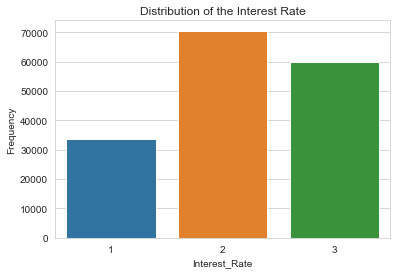

In [20]:
sns.countplot(x="Interest_Rate",data=train)
plt.ylabel("Frequency")
plt.title("Distribution of the Interest Rate")

Now let's visualize each variable separately. Different types of variables are Categorical, ordinal and numerical.

In [21]:
train.select_dtypes(["object"]).columns

Index(['Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Income_Verified', 'Purpose_Of_Loan', 'Gender'],
      dtype='object')

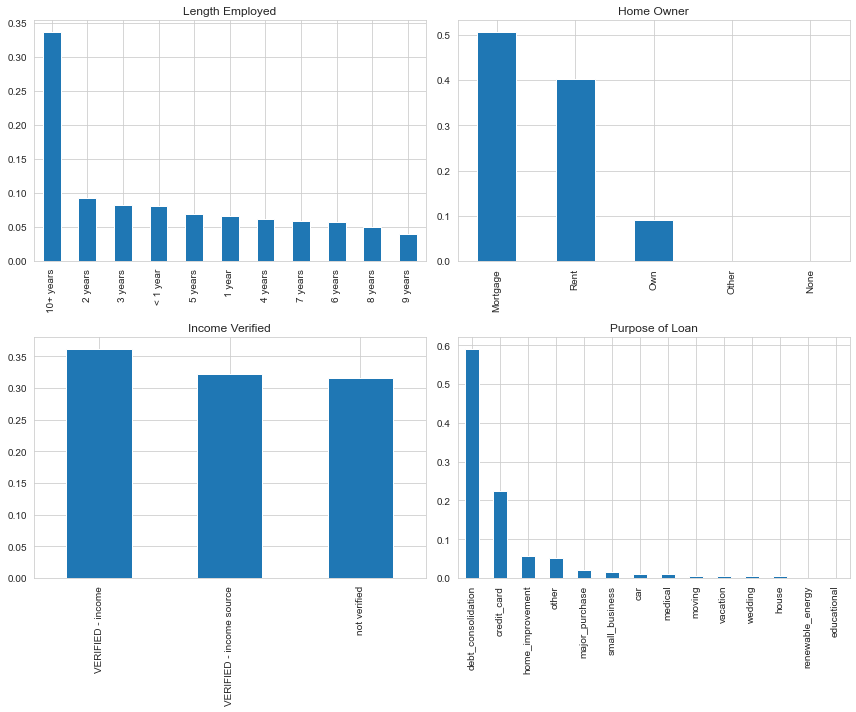

In [22]:
f, axes = plt.subplots(2,2,figsize=(12,10))
train["Length_Employed"].value_counts(normalize=True,sort=True).plot.bar(ax=axes[0,0],title="Length Employed")
train["Home_Owner"].value_counts(normalize=True,sort=True).plot.bar(ax=axes[0,1],title="Home Owner")
train["Income_Verified"].value_counts(normalize=True,sort=True).plot.bar(ax=axes[1,0],title="Income Verified")
train["Purpose_Of_Loan"].value_counts(normalize=True,sort=True).plot.bar(ax=axes[1,1],title="Purpose of Loan")
plt.tight_layout()

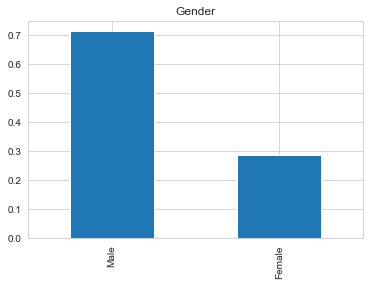

In [23]:
train["Gender"].value_counts(normalize=True).plot.bar(title='Gender')

It can be inferred from the above bar plots that:

*   There's an almost equal distribution of loan applicants within the three categories of income verification.
*   Mortgage and Rent clients combined make up the bulk of applicants for the accomodation arrangements (~91%).
*   Applicants whose length of employment is 10+ years make up the majority (~34%) of the clients. This is expected as they could be more sure of job/income security to service the loan.
*   Over 70% of the clients are Male.





In [24]:
train.select_dtypes(["float"]).columns

Index(['Annual_Income', 'Debt_To_Income', 'Months_Since_Deliquency'], dtype='object')

Text(0.5, 1.0, 'Histogram of the Annual Income')

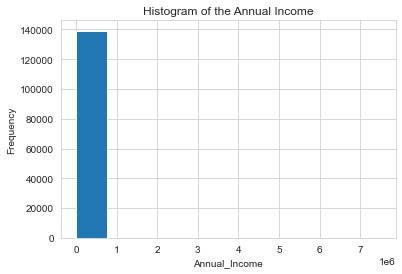

In [25]:
train["Annual_Income"].hist()
plt.xlabel("Annual_Income")
plt.ylabel("Frequency")
plt.title("Histogram of the Annual Income")

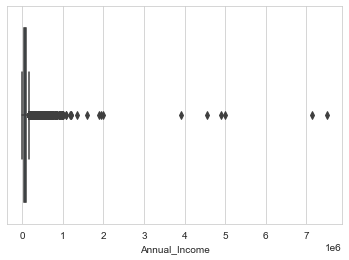

In [26]:
sns.boxplot(train["Annual_Income"])

It can be inferred that most of the data in the distribution of the applicant is towards the left which means it is not normally distributed. This will be dealt with later as algorithms work better with data that is normally distributed. 

The boxplot confirms the presence of a lot of outliers. This can be attributed to the income disparity in the society. 

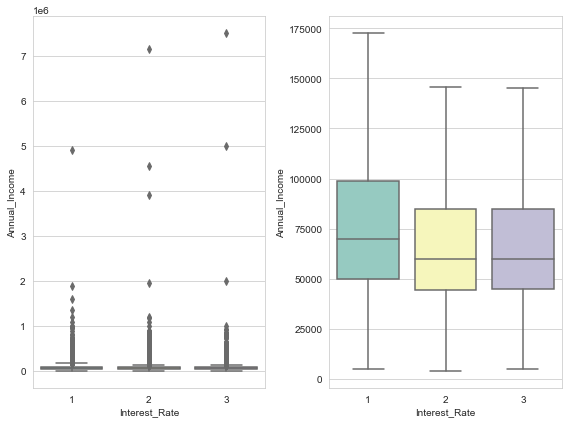

In [27]:
f, axes = plt.subplots(1,2,figsize=(8,6))
sns.boxplot(x='Interest_Rate',y='Annual_Income',data=train,ax=axes[0],palette="Set3",showfliers=True)
sns.boxplot(x='Interest_Rate',y='Annual_Income',data=train,ax=axes[1],palette="Set3",showfliers=False)
plt.tight_layout()

Text(0, 0.5, 'Frequency')

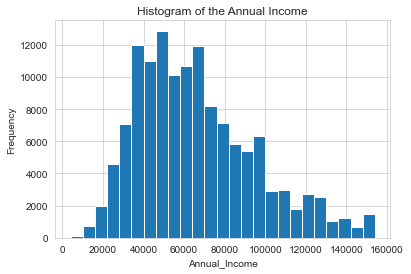

In [28]:
col = ["Annual_Income"]
Q1 = train[col].quantile(0.25)
Q3 = train[col].quantile(0.75)
IQR = Q3 - Q1
train_filter_Income_outlier = train[~((train[col] < (Q1 - 1.5 * IQR)) |(train[col] > (Q3 + 1.5 * IQR))).any(axis=1)]
train_filter_Income_outlier["Annual_Income"].hist(bins=25)
plt.title("Histogram of the Annual Income")
plt.xlabel("Annual_Income")
plt.ylabel("Frequency")

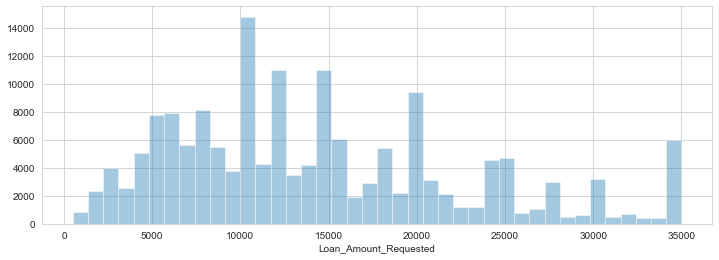

In [29]:
train['Loan_Amount_Requested'] = train['Loan_Amount_Requested'].str.replace(',','')
train['Loan_Amount_Requested'] = train['Loan_Amount_Requested'].astype(float)

test['Loan_Amount_Requested'] = test['Loan_Amount_Requested'].str.replace(',','')
test['Loan_Amount_Requested'] = test['Loan_Amount_Requested'].astype(float)


plt.figure(figsize=(12,4))
sns.distplot(train['Loan_Amount_Requested'],kde=False,bins=40)

Text(0.5, 1.0, 'Histogram of Debt_To_Income')

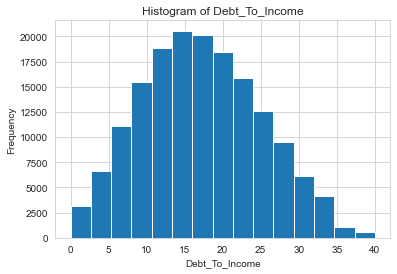

In [30]:
train["Debt_To_Income"].hist(bins=15)
plt.xlabel("Debt_To_Income")
plt.ylabel("Frequency")
plt.title("Histogram of Debt_To_Income")

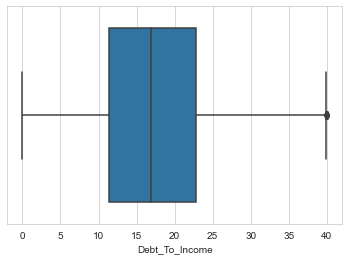

In [31]:
sns.boxplot(train["Debt_To_Income"])



*   It can be inferred from the Debt_To_Income ratio, there are few outliers. This is expected as debt is usually comensurate to income levels.



Text(0, 0.5, 'Frequency')

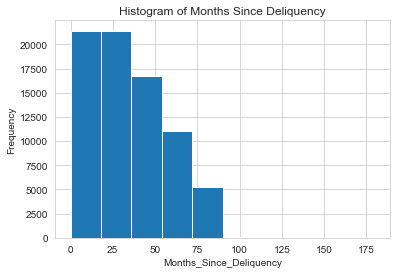

In [32]:
train["Months_Since_Deliquency"].hist()
plt.title("Histogram of Months Since Deliquency")
plt.xlabel("Months_Since_Deliquency")
plt.ylabel("Frequency")

In [33]:
train.select_dtypes(["int64"]).columns

Index(['Loan_ID', 'Inquiries_Last_6Mo', 'Number_Open_Accounts',
       'Total_Accounts', 'Interest_Rate'],
      dtype='object')

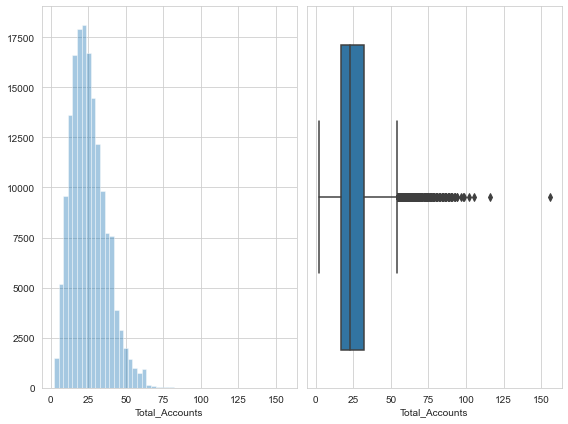

In [34]:
f,axes = plt.subplots(1,2,figsize=(8,6))
sns.distplot(train["Total_Accounts"],ax=axes[0],kde=False,hist=True)
sns.boxplot(train["Total_Accounts"],ax=axes[1])
plt.tight_layout()

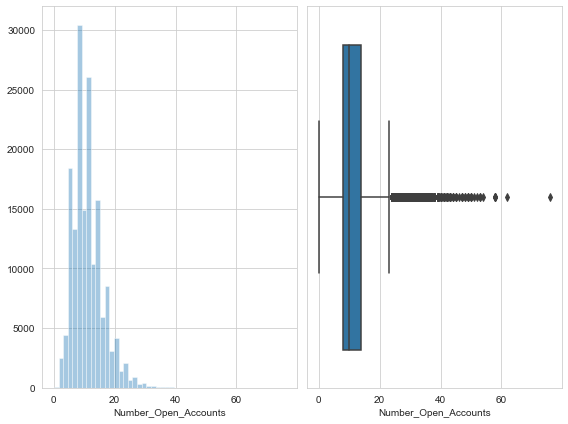

In [35]:
f,axes = plt.subplots(1,2,figsize=(8,6))
sns.distplot(train["Number_Open_Accounts"],ax=axes[0],kde=False,hist=True)
sns.boxplot(train["Number_Open_Accounts"],ax=axes[1])
plt.tight_layout()

Text(0, 0.5, 'Frequency')

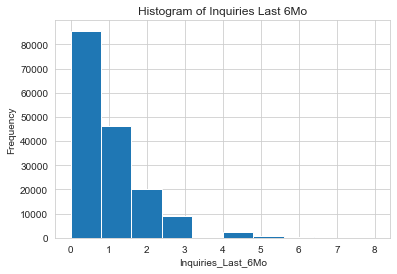

In [36]:
train["Inquiries_Last_6Mo"].hist()
plt.title("Histogram of Inquiries Last 6Mo")
plt.xlabel("Inquiries_Last_6Mo")
plt.ylabel("Frequency")

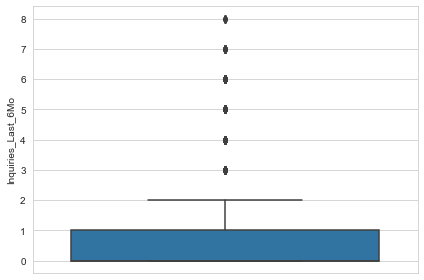

In [37]:
sns.boxplot(train["Inquiries_Last_6Mo"],orient='v')
plt.tight_layout()

**Bivariate Analysis**

First we will find the relation between the target variable and categorical independent variables. 

In [38]:
train.groupby('Gender')["Interest_Rate"].value_counts().unstack()

Interest_Rate,1,2,3
Gender,,,
Female,9669,20415,17049
Male,24137,50165,42874


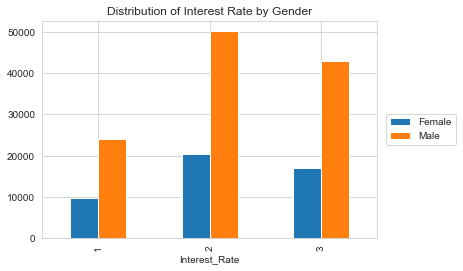

In [39]:
Gender = pd.crosstab(train["Interest_Rate"],train["Gender"])
Gender.plot.bar()
plt.title("Distribution of Interest Rate by Gender")
plt.xlabel("Interest_Rate")
plt.legend(loc="center right",bbox_to_anchor=(1.25,0.5))



*   There are more Males within each Interest_Rate categorization. This is expected as Males make up over 70% of the dataset.



Now let us visualize the remaining categorical variables versus the target variable.

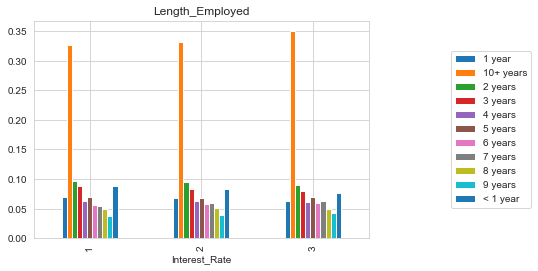

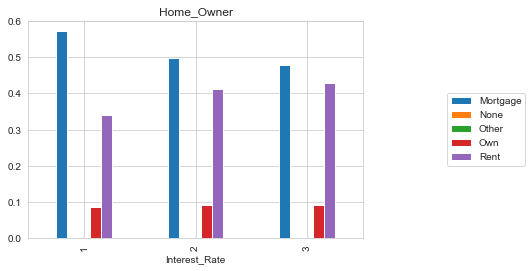

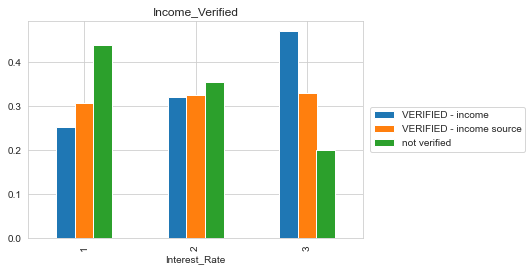

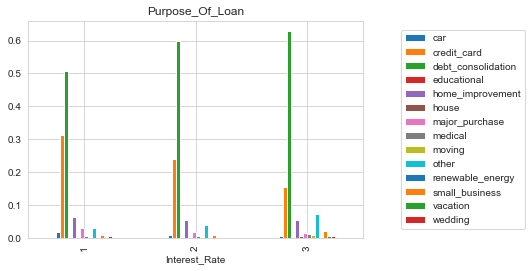

In [40]:
Length_Employed = pd.crosstab(train['Interest_Rate'],train['Length_Employed'])
Home_Owner = pd.crosstab(train['Interest_Rate'],train['Home_Owner'])
Income_Verified = pd.crosstab(train['Interest_Rate'],train['Income_Verified'])
Purpose_Of_Loan = pd.crosstab(train['Interest_Rate'],train['Purpose_Of_Loan'])

Length_Employed.div(Length_Employed.sum(1).astype(float),axis=0).plot(kind='bar',title='Length_Employed')
plt.legend(loc='center right',bbox_to_anchor=(1.5,0.5))
Home_Owner.div(Home_Owner.sum(1).astype(float),axis=0).plot(kind='bar',title='Home_Owner')
plt.legend(loc='center right',bbox_to_anchor=(1.5,0.5))
Income_Verified.div(Income_Verified.sum(1).astype(float),axis=0).plot(kind='bar',title='Income_Verified')
plt.legend(loc='center right',bbox_to_anchor=(1.5,0.5))
Purpose_Of_Loan.div(Purpose_Of_Loan.sum(1).astype(float),axis=0).plot(kind='bar',title='Purpose_Of_Loan')
plt.legend(loc='center right',bbox_to_anchor=(1.5,0.5))



*   Proportion of applicants whose purpose of loan is debt consolidation is higher within each Interest_Rate classification.
*   It is also notable also that it is only in Interest_Rate categorisation 3 where the VERIFIED-income is highest proportion.



Now lets look at the correlation between all the numerical variables. We will use the heatmap to visualize the correlation.

In [41]:
train.corr()

,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Interest_Rate
Loan_ID,1.000000,0.001305,0.008326,-0.001320,0.002593,0.002111,0.004626,0.005331,0.001290
Loan_Amount_Requested,0.001305,1.000000,0.337695,0.058314,-0.007659,-0.044224,0.203087,0.233424,0.132486
Annual_Income,0.008326,0.337695,1.000000,-0.173589,0.060011,-0.057804,0.145822,0.203237,-0.052783
Debt_To_Income,-0.001320,0.058314,-0.173589,1.000000,-0.005142,0.006394,0.302442,0.229871,0.152472
Inquiries_Last_6Mo,0.002593,-0.007659,0.060011,-0.005142,1.000000,0.011971,0.100930,0.131467,0.188987
Months_Since_Deliquency,0.002111,-0.044224,-0.057804,0.006394,0.011971,1.000000,-0.049683,-0.062261,-0.042108
Number_Open_Accounts,0.004626,0.203087,0.145822,0.302442,0.100930,-0.049683,1.000000,0.682137,0.002847
Total_Accounts,0.005331,0.233424,0.203237,0.229871,0.131467,-0.062261,0.682137,1.000000,-0.040690
Interest_Rate,0.001290,0.132486,-0.052783,0.152472,0.188987,-0.042108,0.002847,-0.040690,1.000000


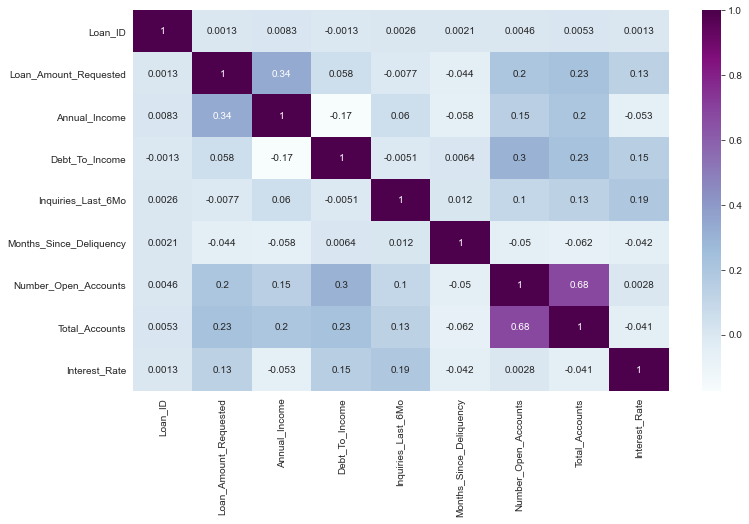

In [42]:
plt.figure(figsize=(12,7))
sns.heatmap(train.corr(),cmap="BuPu",annot=True)



*   There seems to be a fairly considerable correlation between the Annual Income & Loan_Amount Requested and the Total Accounts & Number of Open Accounts. Let us explore this further.


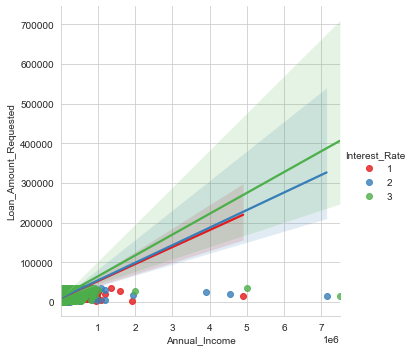

In [43]:
sns.lmplot(x="Annual_Income",y="Loan_Amount_Requested",data=train,hue="Interest_Rate",palette="Set1")

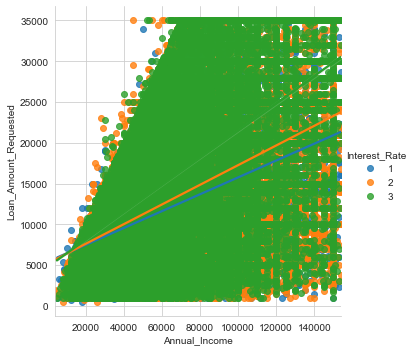

In [44]:
col = ["Annual_Income"]
Q1 = train[col].quantile(0.25)
Q3 = train[col].quantile(0.75)
IQR = Q3 - Q1
train_filter_Income_outlier = train[~((train[col] < (Q1 - 1.5 * IQR)) |(train[col] > (Q3 + 1.5 * IQR))).any(axis=1)]
sns.lmplot(x="Annual_Income",y="Loan_Amount_Requested",data=train_filter_Income_outlier,hue="Interest_Rate")

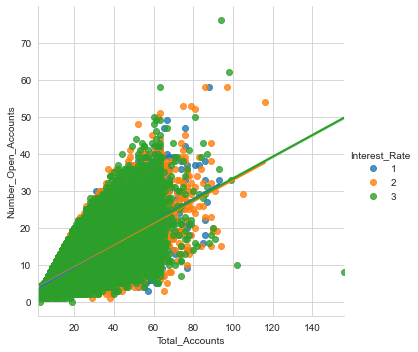

In [45]:
sns.lmplot(x="Total_Accounts",y="Number_Open_Accounts",data=train,hue="Interest_Rate")

# **Missing Value Treatment**

In [46]:
def nan_check(data):
    total = data.isnull().sum().sort_values(ascending=False)
    pct = round(100*data.isnull().sum()/data.shape[0],2)
    missing_data = pd.concat([total,pct],axis=1,keys=["Total # Of Missing Values","% NAN"])
    return missing_data

nan_check(train)

,Total # Of Missing Values,% NAN
Months_Since_Deliquency,88379,53.79
Home_Owner,25349,15.43
Annual_Income,25102,15.28
Length_Employed,7371,4.49
Interest_Rate,0,0.00
Gender,0,0.00
Total_Accounts,0,0.00
Number_Open_Accounts,0,0.00
Inquiries_Last_6Mo,0,0.00
Debt_To_Income,0,0.00


In [47]:
import missingno as msno

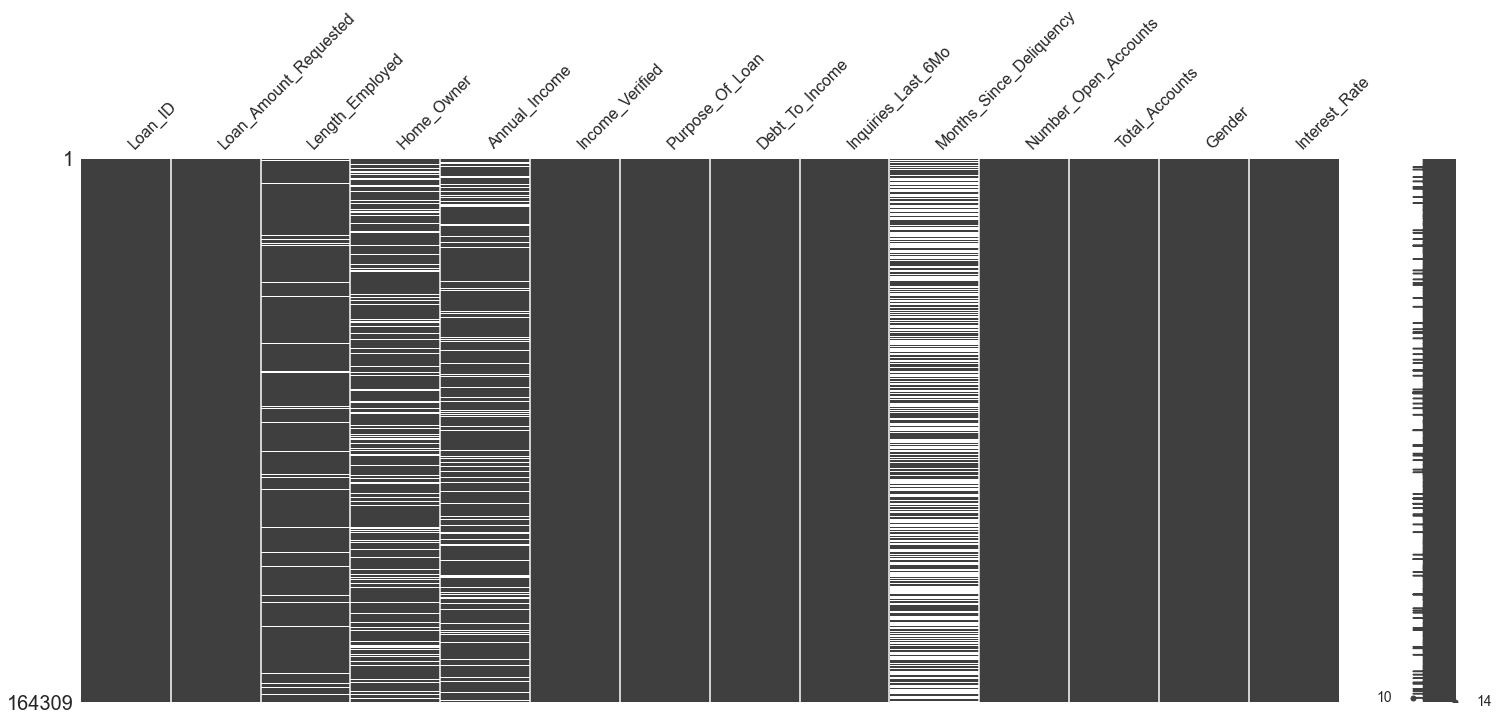

In [48]:
msno.matrix(train)

<Figure size 864x720 with 0 Axes>

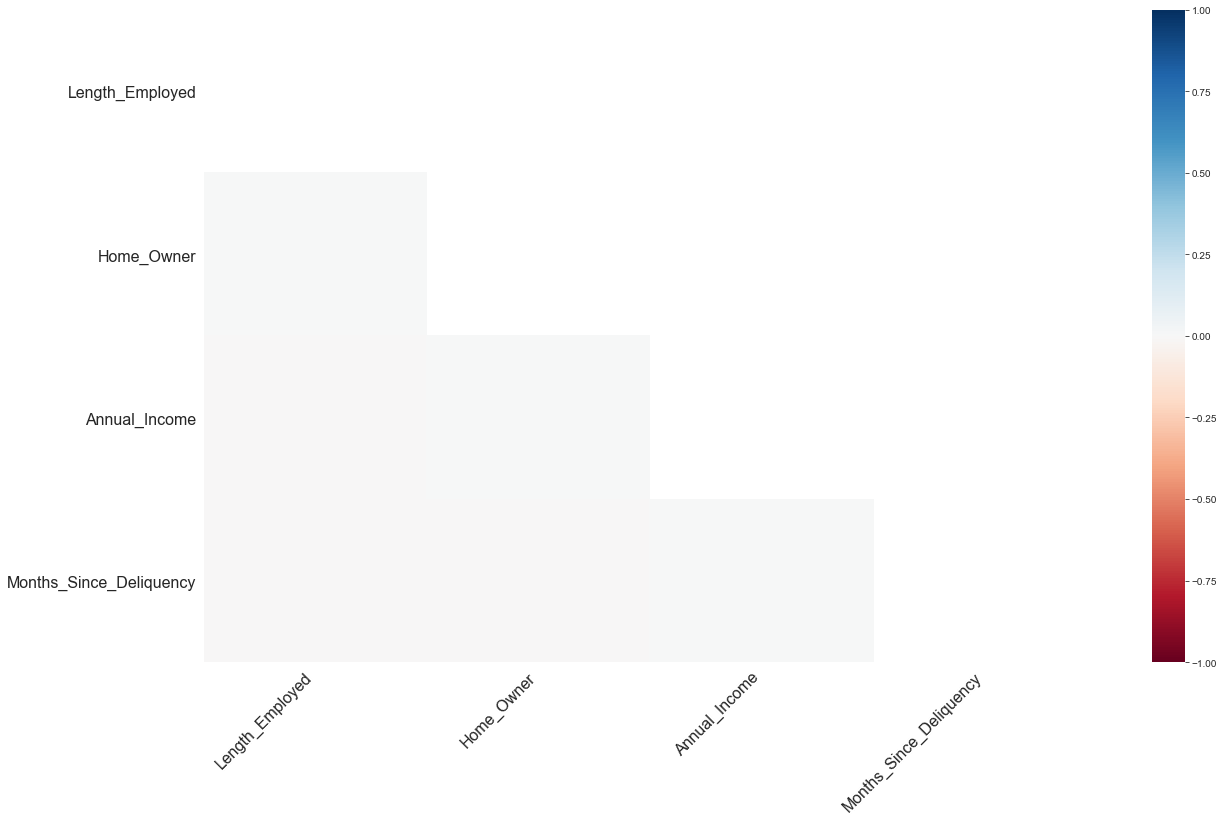

In [49]:
plt.figure(figsize=(12,10))
msno.heatmap(train)

In [50]:
len(train)

164309

**Let's examine the Length_Employed to see whether it will be ok to drop the column. Print out the feature information  using the feat_info() function from the top of this notebook.**

In [51]:
feat_info('Length_Employed')

Employment length in years


In [52]:
sorted(train["Length_Employed"].dropna().unique())

['1 year',
 '10+ years',
 '2 years',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years',
 '< 1 year']

**Create a countplot of the Length_Employed feature column and sort the order of the values.**

In [53]:
Length_Employed_Order = [ '< 1 year',
                      '1 year',
                     '2 years',
                     '3 years',
                     '4 years',
                     '5 years',
                     '6 years',
                     '7 years',
                     '8 years',
                     '9 years',
                     '10+ years']

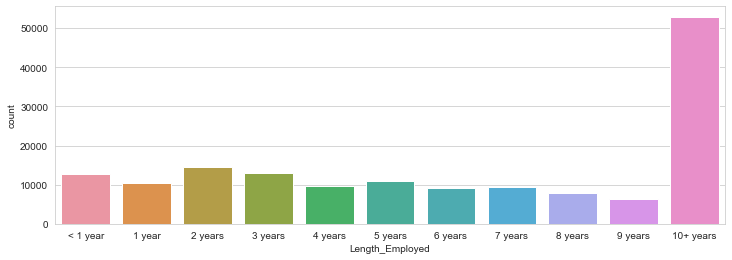

In [54]:
plt.figure(figsize=(12,4))
sns.countplot(x='Length_Employed',data=train,order=Length_Employed_Order)

**Plot out the countplot with a hue of the Interest_Rate.**

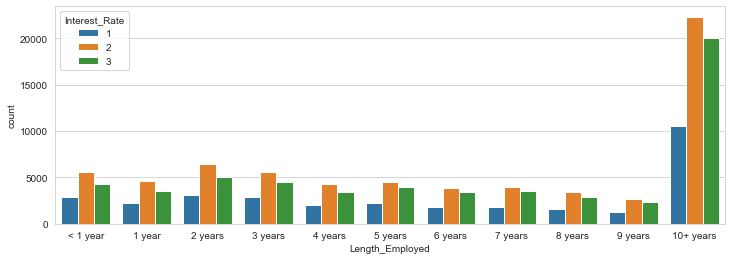

In [55]:
plt.figure(figsize=(12,4))
sns.countplot(x='Length_Employed',data=train,order=Length_Employed_Order,hue='Interest_Rate')

**TASK: This still doesn't really inform us is there is a strong relationship between employment length and the interest rate, what we want is the fraction of interest rates per category. Essentially informing us what percent of people per employment category are assigned to an interest rate category. Create this Series by considering each Interest_Rate category for every employment length and plot the result on a bar plot.**

In [56]:
emp_1 = train[train['Interest_Rate']==1].groupby('Length_Employed').count()['Interest_Rate']

In [57]:
emp_2 = train[train['Interest_Rate']==2].groupby('Length_Employed').count()['Interest_Rate']

In [58]:
emp_3 = train[train['Interest_Rate']==3].groupby('Length_Employed').count()['Interest_Rate']

In [59]:
emp_len_1_2_3 = emp_1/(emp_2+emp_3)
emp_len_1_2_3

Length_Employed
1 year       0.277676
10+ years    0.250384
2 years      0.269428
3 years      0.280624
4 years      0.266537
5 years      0.262433
6 years      0.251755
7 years      0.234810
8 years      0.252690
9 years      0.241359
< 1 year     0.288229
Name: Interest_Rate, dtype: float64

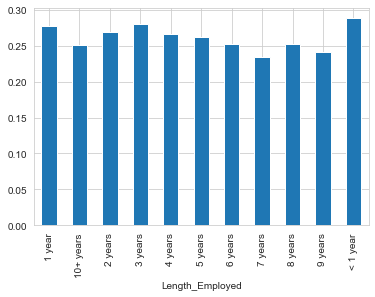

In [60]:
emp_len_1_2_3.plot(kind='bar')

In [61]:
emp_len_2_1_3 = emp_2/(emp_1 + emp_3)
emp_len_2_1_3

Length_Employed
1 year       0.790106
10+ years    0.730040
2 years      0.783797
3 years      0.763970
4 years      0.777616
5 years      0.725271
6 years      0.740145
7 years      0.748638
8 years      0.779501
9 years      0.741480
< 1 year     0.780451
Name: Interest_Rate, dtype: float64

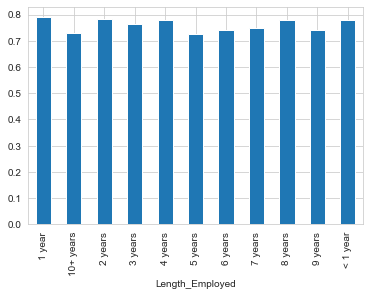

In [62]:
emp_len_2_1_3.plot(kind='bar')

In [63]:
emp_len_3_2_1 = emp_3/(emp_1+emp_2)
emp_len_3_2_1

Length_Employed
1 year       0.518135
10+ years    0.607137
2 years      0.534586
3 years      0.533207
4 years      0.543461
5 years      0.591699
6 years      0.596279
7 years      0.617376
8 years      0.563080
9 years      0.612365
< 1 year     0.510380
Name: Interest_Rate, dtype: float64

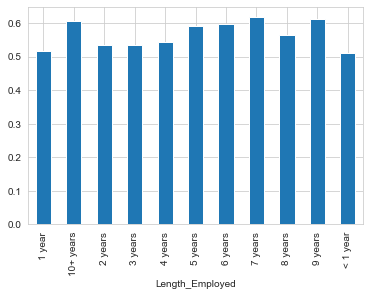

In [64]:
emp_len_3_2_1.plot(kind='bar')

**Interest_Rates are quite similary across all employment lengths.**

In [65]:
train["Length_Employed"] = train["Length_Employed"].replace({ '< 1 year': "0-3 years",
                                                             '1 year': "0-3 years",
                                                             '2 years': "0-3 years",
                                                             '3 years': "0-3 years",
                                                             '4 years': "4-6 years",
                                                             '5 years':"4-6 years",
                                                             '6 years':"4-6 years",
                                                             '7 years':"7-10+ years",
                                                             '8 years':"7-10+ years",
                                                             '9 years':"7-10+ years",
                                                             '10+ years':"7-10+ years"})

test["Length_Employed"] = test["Length_Employed"].replace({ '< 1 year': "0-3 years",
                                                             '1 year': "0-3 years",
                                                             '2 years': "0-3 years",
                                                             '3 years': "0-3 years",
                                                             '4 years': "4-6 years",
                                                             '5 years':"4-6 years",
                                                             '6 years':"4-6 years",
                                                             '7 years':"7-10+ years",
                                                             '8 years':"7-10+ years",
                                                             '9 years':"7-10+ years",
                                                             '10+ years':"7-10+ years"})

**Over 53 % of the data for entries of Months_Since_Deliquency are missing. Drop this feature.**

In [66]:
feat_info('Months_Since_Deliquency')

The number of months since the borrower's last delinquency.


In [67]:
train = train.drop("Months_Since_Deliquency",axis=1)
test = test.drop("Months_Since_Deliquency",axis=1)

**Annual_Income feature**

Find out what the Annual_Income feature represents

In [68]:
feat_info('Annual_Income')

The annual income provided by the borrower during registration.


**Create a value_counts() of the Annual_Income**

In [69]:
train['Annual_Income'].value_counts()

60000.0     5462
50000.0     4783
65000.0     4012
40000.0     3856
70000.0     3667
            ... 
116757.0       1
27950.0        1
83982.0        1
384635.0       1
79678.0        1
Name: Annual_Income, Length: 12305, dtype: int64

**There are many ways we could deal with this missing data. We could attempt to build a simple model to fill it in, such as a linear model, we could just fill it in based on the mean of the other columns, or you could even bin the columns into categories and then set NaN as its own category. There is no 100% correct approach! Let's review the other columsn to see which most highly correlates to Annual_Income.**

In [70]:
print("Correlation with the Annual_Income column")
train.corr()["Annual_Income"].sort_values(ascending=False)

Correlation with the Annual_Income column


Annual_Income            1.000000
Loan_Amount_Requested    0.337695
Total_Accounts           0.203237
Number_Open_Accounts     0.145822
Inquiries_Last_6Mo       0.060011
Loan_ID                  0.008326
Interest_Rate           -0.052783
Debt_To_Income          -0.173589
Name: Annual_Income, dtype: float64

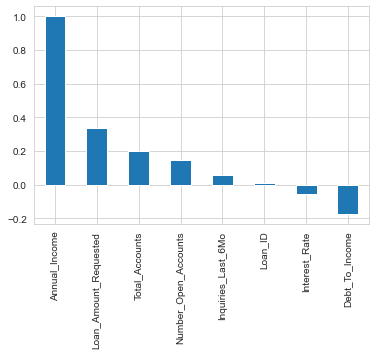

In [71]:
train.corr()["Annual_Income"].sort_values(ascending=False).plot.bar()

**Looks like the Loan_Amount_Requested feature correlates with the Annual_Income, this is expected. We will group the dataframe by the Loan_Amount_Requested and calculate the mean for the Annual_Income per Loan_Amount_Requested entry.**

In [72]:
print("Mean of Annual_Income")
train.groupby('Loan_Amount_Requested').mean()["Annual_Income"]

Mean of Annual_Income


Loan_Amount_Requested
500.0       17301.346667
725.0       12000.000000
750.0       19000.000000
800.0       35000.000000
900.0       57000.000000
               ...      
34850.0    124437.760000
34875.0    111857.142857
34925.0    137411.000000
34975.0    150600.000000
35000.0    141518.766116
Name: Annual_Income, Length: 1290, dtype: float64

**Let's fill in the missing Annual_Income values based on their Loan_Amount_Requested value. If the Annual_Income is missing, then we will fill in that missing value with the mean value corresponding to its Loan_Amount_Requested value from the Series we created above. This involves using an .apply() method with two columns.**

In [73]:
Loan_Amount_Requested_avg = train.groupby('Loan_Amount_Requested').mean()["Annual_Income"] 

In [74]:
Loan_Amount_Requested_avg[34925.0]

137411.0

In [75]:
def fill_Annual_Income(Loan_Amount_Requested,Annual_Income):
    '''
    Accepts the Loan_Amount_Requested and Annual_Income values for the row.
    Checks if the Annual_Income is NaN , if so, it returns the avg Annual_Income value
    for the corresponding Loan_Amount_Requested value for that row.
    
    Loan_Amount_Requested_avg here should be a Series or dictionary containing the mapping of the
    groupby averages of Annual_Income per Loan_Amount_Requested values.
    '''
    if np.isnan(Annual_Income):
        return Loan_Amount_Requested_avg[Loan_Amount_Requested]
    else:
        return Annual_Income

In [76]:
train["Annual_Income"] = train.apply(lambda x: fill_Annual_Income(x["Loan_Amount_Requested"],x["Annual_Income"]),axis=1)

In [77]:
Loan_Amount_Requested_avg = test.groupby('Loan_Amount_Requested').mean()["Annual_Income"] 

def fill_Annual_Income(Loan_Amount_Requested,Annual_Income):
    if np.isnan(Annual_Income):
        return Loan_Amount_Requested_avg[Loan_Amount_Requested]
    else:
        return Annual_Income
    
test["Annual_Income"] = test.apply(lambda x: fill_Annual_Income(x["Loan_Amount_Requested"],x["Annual_Income"]),axis=1)

In [78]:
nan_check(train)

,Total # Of Missing Values,% NAN
Home_Owner,25349,15.43
Length_Employed,7371,4.49
Annual_Income,11,0.01
Interest_Rate,0,0.00
Gender,0,0.00
Total_Accounts,0,0.00
Number_Open_Accounts,0,0.00
Inquiries_Last_6Mo,0,0.00
Debt_To_Income,0,0.00
Purpose_Of_Loan,0,0.00


**This leaves 11 entries of the Annual_Income still missing in the training dataset. These would be handled by the LGB model.**

# **Categorical Variables and Dummy Variables**

In [79]:
train.shape,test.shape

((164309, 13), (109541, 12))

In [80]:
train["Home_Owner"].value_counts()

Mortgage    70345
Rent        56031
Own         12525
Other          49
None           10
Name: Home_Owner, dtype: int64

In [81]:
train['Home_Owner'] = train['Home_Owner'].fillna(train['Home_Owner'].mode()[0])
test['Home_Owner'] = test['Home_Owner'].fillna(test['Home_Owner'].mode()[0])

In [82]:
train.select_dtypes(["object"]).columns

Index(['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan',
       'Gender'],
      dtype='object')

In [83]:
train[['Home_Owner', 'Income_Verified', 'Purpose_Of_Loan', 'Gender']].nunique()

Home_Owner          5
Income_Verified     3
Purpose_Of_Loan    14
Gender              2
dtype: int64

In [84]:
train['Gender']= train['Gender'].replace({'Male':1,'Female':0})
test['Gender']= test['Gender'].replace({'Male':1,'Female':0})

In [85]:
train["Interest_Rate"] = train["Interest_Rate"].replace({1:0, 2:1, 3:2})

In [86]:
cols = ['Home_Owner', 'Income_Verified', 'Purpose_Of_Loan',"Length_Employed"]
train_dummies = pd.get_dummies(train[cols],drop_first=True)
test_dummies = pd.get_dummies(test[cols],drop_first=True)
train = pd.concat([train.drop(cols,axis=1),train_dummies],axis=1)
test = pd.concat([test.drop(cols,axis=1),test_dummies],axis=1)

# **New Created Features** 

In [102]:
train["Number_Closed_Accounts"] = train["Total_Accounts"] - train["Number_Open_Accounts"]
test["Number_Closed_Accounts"] = test["Total_Accounts"] - test["Number_Open_Accounts"]

In [103]:
train.columns

Index(['Loan_ID', 'Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Number_Open_Accounts', 'Total_Accounts',
       'Gender', 'Interest_Rate', 'Home_Owner_None', 'Home_Owner_Other',
       'Home_Owner_Own', 'Home_Owner_Rent',
       'Income_Verified_VERIFIED - income source',
       'Income_Verified_not verified', 'Purpose_Of_Loan_credit_card',
       'Purpose_Of_Loan_debt_consolidation', 'Purpose_Of_Loan_educational',
       'Purpose_Of_Loan_home_improvement', 'Purpose_Of_Loan_house',
       'Purpose_Of_Loan_major_purchase', 'Purpose_Of_Loan_medical',
       'Purpose_Of_Loan_moving', 'Purpose_Of_Loan_other',
       'Purpose_Of_Loan_renewable_energy', 'Purpose_Of_Loan_small_business',
       'Purpose_Of_Loan_vacation', 'Purpose_Of_Loan_wedding',
       'Length_Employed_4-6 years', 'Length_Employed_7-10+ years',
       'Number_Closed_Accounts'],
      dtype='object')

In [112]:
k = ['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Number_Open_Accounts', 'Total_Accounts',
       'Gender', 'Home_Owner_None', 'Home_Owner_Other',
       'Home_Owner_Own', 'Home_Owner_Rent',
       'Income_Verified_VERIFIED - income source',
       'Income_Verified_not verified', 'Purpose_Of_Loan_credit_card',
       'Purpose_Of_Loan_debt_consolidation', 'Purpose_Of_Loan_educational',
       'Purpose_Of_Loan_home_improvement', 'Purpose_Of_Loan_house',
       'Purpose_Of_Loan_major_purchase', 'Purpose_Of_Loan_medical',
       'Purpose_Of_Loan_moving', 'Purpose_Of_Loan_other',
       'Purpose_Of_Loan_renewable_energy', 'Purpose_Of_Loan_small_business',
       'Purpose_Of_Loan_vacation', 'Purpose_Of_Loan_wedding',
       'Length_Employed_4-6 years', 'Length_Employed_7-10+ years',
       'Number_Closed_Accounts']

# **Train Test split**

In [113]:
from sklearn.model_selection import StratifiedKFold,KFold,GridSearchCV,GroupKFold,train_test_split

In [114]:
X = train.drop(["Loan_ID","Interest_Rate"],axis=1)
y = train["Interest_Rate"]

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

# **Creating the Model**

In [116]:
splits = 5
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=22)
oof_preds = np.zeros((len(test), 3))
feature_importance_df = pd.DataFrame()
final_preds = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        print("Fold {}".format(fold_))
        X_trn,y_trn = X_train[k].iloc[trn_idx],y_train.iloc[trn_idx]
        X_val,y_val = X_train[k].iloc[val_idx],y_train.iloc[val_idx]
        clf = lgb.LGBMClassifier(random_state=22,n_jobs=-1,max_depth=-1,min_data_in_leaf=24,num_leaves=49,bagging_fraction=0.01,
                        colsample_bytree=1.0,lambda_l1=1,lambda_l2=11,learning_rate=0.1,n_estimators=5000)
        clf.fit(X_trn, y_trn, eval_metric='multi_logloss', eval_set=[(X_val,y_val)], verbose=False,early_stopping_rounds=100)
        y_val_preds = clf.predict_proba(X_val)
        final_preds.append(f1_score(y_pred=[np.argmax(x) for x in y_val_preds],y_true=y_val,average='weighted'))
#         predictions += clf.predict_proba(X_valid)
        oof_preds += clf.predict_proba(test[k])
#         counter = counter + 1
oof_preds = oof_preds/splits
print(sum(final_preds)/5)

Fold 0
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] bagging_fraction is set=0.01, subsample=1.0 will be ignored. Current value: bagging_fraction=0.01
[LightGBM] [Warning] lambda_l2 is set=11, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11
Fold 1
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] bagging_fraction is set=0.01, subsample=1.0 will be ignored. Current value: bagging_fraction=0.01
[LightGBM] [Warning] lambda_l2 is set=11, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11
Fold 2
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current 

In [117]:
print(clf.feature_importances_)

[4313 3618 3797  860 1634 1790  161    0    0  106  301  216  310  374
  220   61   67   56   89  103  102  242   20  125   76   47  124  252
 1960]


<BarContainer object of 29 artists>

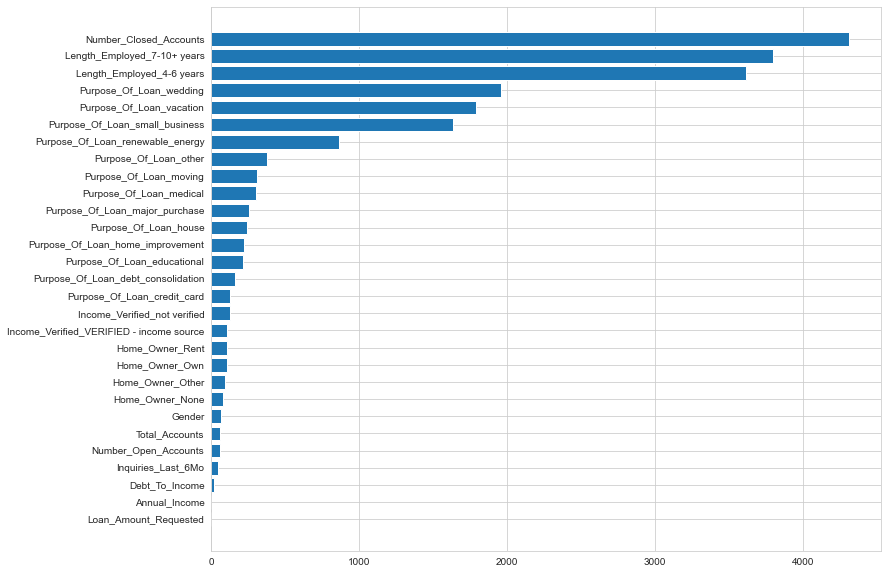

In [118]:
plt.figure(figsize=(12,10))
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X.columns, clf.feature_importances_[sorted_idx])

In [119]:
submission['Interest_Rate'] = [np.argmax(x) for x in oof_preds]
submission['Interest_Rate'] = submission['Interest_Rate'].replace({0:1, 1:2, 2:3})
submission.to_csv('Interest_Rate.csv',index=False)